In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import theano
import numpy as np
import matplotlib.pyplot as plt

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '24147' (I am process '22802')
Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


$\textbf{Indicator function approximation}$ 

Suppose that indicator function  $H(x) = 1[x>0]$ can be approximated by polynomial $\sum_{k=0}^d c_k x^k$ above. 

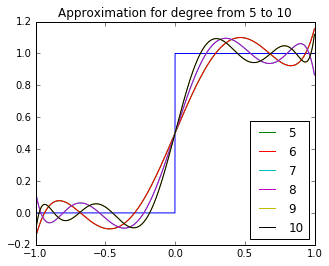

In [2]:
###   chebyshev estimation for indicator loss function #########
#     for deg from 5 to 10

x = np.arange(-1, 1, 0.001)
y = np.sign(x); y [ y == -1] = 0

c_all = dict()
fig = plt.figure(figsize=(5, 4))
plt.plot(x,y)

for deg in xrange(5, 11, 1):   
    c = np.polynomial.chebyshev.chebfit(x, y, deg)
    y3 = []
    for xx in x:
        y3.append( np.polynomial.chebyshev.chebval(xx, c))
    plt.plot(x,y3, label=str(deg))
    c_all[deg] = c

plt.title('Approximation for degree from 5 to 10')
plt.legend(loc=4)

for degree 7 , its coefs are 0.5013 2.6917 -0.0148 -9.8694 0.0385 15.3964 -0.0275 -7.8554 , and its approximation is


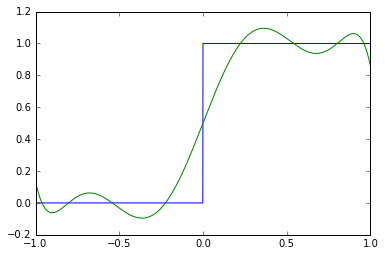

In [3]:
# we compute C_k in this cell for degree from 5 to 10

def ComputePoly(coef_poly, x):
    res = 0
    for idx, c in enumerate(coef_poly):
        res += c * np.power(x, idx)
    return res

coef_poly = dict()
for d in c_all:
    coef_poly[d] = np.polynomial.chebyshev.cheb2poly(c_all[d])

d = 7
y4 = []
for xx in x:
    y4.append( ComputePoly(coef_poly[d], xx))
plt.plot(x,y)
plt.plot(x,y4)
print 'for degree', d, ', its coefs are', ' '.join( [str(np.round(c, 4)) for c in coef_poly[d]] ), \
      ', and its approximation is'

$\textbf{AUC estimation}$

AUC of a predictor $f$ is defined as (where $f$ could be logistic, SVM, CNN or so on)
$$ AUC(f) = P( f(x) < f(y) \large \vert x \in D^0, y \in D^1)$$, 
where $D^0, D^1$ are the samples with true label 0 and 1 respectively. Therefore its naive estimation, i.e. Wilcoxon-Man-Whitney statistics, is
$$ n_0 n_1 auc(f ) = \sum_{t_0\in D^0} \sum_{t_1 \in D^1} 1 [ f(t_0) < f(t_1) ] $$, 
where $n_0 = |D^0|, n_1 = |D^1|$.  The computation cost for WMW statistics is equivalent to sort $f(t)$

now consider approximate indicator function 1 by polynomial with degree $k$ above, i.e.
$$
\begin{align}
H( f(t_1) - f(t_0) ) & \approx \sum_{k=0}^d c_k (f(t_1) - f(t_0))^k  \\
                     & = \sum_{k=0}^d c_k \sum_{l=0}^k C_k^l f(t_1)^l (-f(t_0))^{k-l} \\
                     & = \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} f(t_1)^l f(t_0)^{k-l}.
\end{align}
$$
where $\alpha_{kl} = c_k C_k^l (-1)^{k-l}$ is the constant, next we compute $\alpha$s

In [4]:
### compute alphas #######
from scipy.special import comb

alphas = dict()

for d in coef_poly:
    a = np.zeros( (d+1, d+1), dtype = np.float32)
    for k in xrange(d+1):
        for l in xrange(k+1):
            a[k,l] = coef_poly[d][k] * comb(k,l) * np.power(-1, k-l)
    alphas[d] = a
np.set_printoptions(precision=3, suppress=True)

$\textbf{AUC Approximation by Polynomial}$

Then AUC can be approxiated by 
$$
\begin{align}
n_0 n_1 AUC(f) &= \sum_{t_0 \in D^0} \sum_{t_1 \in D^1} \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} f(t_1)^l f(t_0)^{k-1} \\
               &= \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} (\sum_{t_1 \in D^1} f(t_1)^l ) ( \sum_{t_0\in D^0} f(t_0)^{k-l})
\end{align}
$$

$\textbf{ An Theano Implementation Complexity Analysis}$

denote $x, y$ as input tensor features and labels, for simplicity assume $y \in \{0, 1\} $

$\textbf{AUC Optimization} $

if you are not going to use Theano and would like to compute the gradient by your self, here is a simple derivation 
$$ n_0 n_1 \frac{ \partial AUC(f)} {\partial w} = \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} 
(\frac{\partial \sum_{t_1\in D_1} f(t_1)^l}{\partial w} * \sum_{t_0 \in D_0} f(t_0)^{k-l}  + 
\sum_{t_1\in D_1} f(t_1)^l * \frac{\partial  \sum_{t_0 \in D_0} f(t_0)^{k-l}}{\partial w} )$$

In [5]:
#randomly generate some data for classification
import sklearn
from sklearn import datasets
from sklearn import linear_model
X, Y =  datasets.make_classification(100, 2, 2, 0, flip_y=0.4)

acc = 0.75


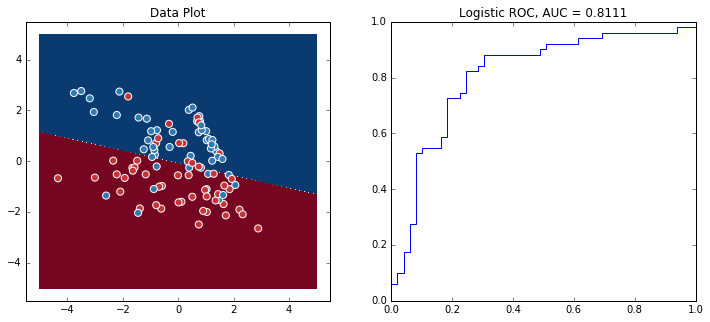

In [6]:
### visualization for 2D data point

X = X.astype(np.float32); Y = Y.astype(np.int32)

fig = plt.figure( figsize=(12, 5) )

ax = fig.add_subplot(121)
plt.title('Data Plot')

log_model =  linear_model.LogisticRegression()
log_model.fit(X, Y)
Y_pred = log_model.predict_proba(X)

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = log_model.predict(grid).reshape(xx.shape)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)

plt.scatter(X[:,0], X[:, 1], c=Y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

fig.add_subplot(122)
fpr, tpr, _ = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
auc = sklearn.metrics.roc_auc_score(Y, Y_pred[:,1])

plt.plot(fpr, tpr)
plt.title('Logistic ROC, AUC = ' + str( np.round(auc,4)) )
print 'acc =', np.mean( np.argmax(Y_pred,1)==Y)

In [7]:
########   now we approximate it ##################
D0 = np.where(Y == 0)[0]; D1 = np.where( Y == 1)[0]

In [11]:
#now we test the AUC estimation/approximation by WMW and polynomial
#which should be not too far from AUC above computed by sklearn

def AUC_WMW(Y_pred, D0, D1):
    auc_WMW = 0
    for i0 in D0:
        for i1 in D1:
            auc_WMW += Y_pred[ i0] < Y_pred[i1]
    auc_WMW /= len(D0) * len(D1) * 1.0
    return auc_WMW

def AUC_Poly0(Y_pred, D0, D1, d=7):
    auc_poly0 = 0
    for i0 in D0:
        for i1 in D1:
            for k in xrange(d+1):
                auc_poly0 += coef_poly[d][k] * np.power( ( Y_pred[ i1] - Y_pred[ i0] ), k)
    auc_poly0 /= len(D0) * len(D1) * 1.0
    return auc_poly0

def AUC_Poly(Y_pred, D0, D1, d=7):
    auc_poly = 0
    for k in xrange(d+1):
        for l in xrange(k+1):
            auc_poly += alphas[d][k,l] * np.sum( np.power( Y_pred[D1], l) ) * np.sum( np.power( Y_pred[D0], k-l ) )
    auc_poly /= len(D0) * len(D1) * 1.0
    return auc_poly

print 'AUC estimated by Wilcoxon-Man-Whitney statistics is', AUC_WMW(Y_pred[:,1], D0, D1)
print 'AUC estimated by Chebyshev approx is (with c)', AUC_Poly0(Y_pred[:,1], D0, D1)
print 'AUC estimated by Chebyshev approx is (with alpha)', AUC_Poly(Y_pred[:,1], D0, D1, 5)

AUC estimated by Wilcoxon-Man-Whitney statistics is 0.81112444978
AUC estimated by Chebyshev approx is (with c) 0.81492785563
AUC estimated by Chebyshev approx is (with alpha) 0.824245119704


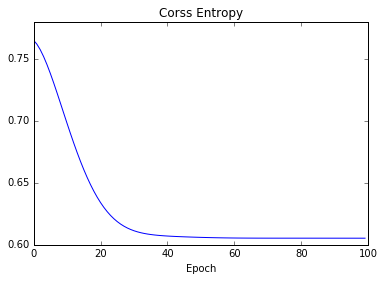

In [18]:
# a simple logistic to optimize cross entropy loss

import lasagne
import theano.tensor as T

x = T.matrix('inputs')
y = T.ivector('targets')

model = lasagne.layers.InputLayer(shape = (None, 2), input_var=x)
model = lasagne.layers.DenseLayer(model, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)

prediction = lasagne.layers.get_output(model, inputs = x)
loss = lasagne.objectives.categorical_crossentropy(prediction, y).mean()

params = lasagne.layers.get_all_params(model, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

train_model = theano.function([x, y], loss, updates=updates)

loss_epoch = []
for i in xrange(100):
    loss_epoch.append( train_model(X.astype(np.float32), (Y).astype(np.int32) ) )
plt.plot(loss_epoch)
plt.title('Corss Entropy')
plt.xlabel('Epoch')

In [19]:
f_pred = theano.function([x], prediction)
target_pred = f_pred(X.astype(np.float32) )
print 'AUC is', AUC_WMW(target_pred[:,1], D0, D1), AUC_Poly(target_pred[:,1], D0, D1)

AUC is 0.721590909091 0.724168517324


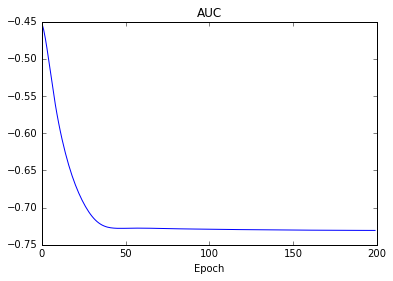

In [21]:
# finally we directly optimized AUC

import lasagne
import theano.tensor as T

x = T.matrix('inputs')
y = T.ivector('targets')

model = lasagne.layers.InputLayer(shape = (None, 2), input_var=x)
model = lasagne.layers.DenseLayer(model, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)

prediction = lasagne.layers.get_output(model, inputs = x)

# the only difference we use here is we use negative AUC as loss
# we analyze the computation cost of AUC. suppose there are n samples
# (d+2) * (d+1) /2 for the for loop
# the sum takes 6n u
# so overall it takes   (d+2)*(d+1)/2 * 8n * N_LABELS operation
# compare to regular cross entropy loss, whose computation cost is N_LABELs * n


label_we_care = 1
init_loss = T.fscalar('auc_loss')
auc_loss = init_loss + 0.0
for k in xrange(d+1):
    for l in xrange(k+1):
        auc_loss = auc_loss-alphas[d][k,l]*T.sum( T.pow( prediction[:,label_we_care], l) *T.eq(y, label_we_care) )\
                                        *T.sum( T.pow( prediction[:,label_we_care], k-l) * T.neq(y, label_we_care))     
auc_loss /= len(D0) * len(D1)      

params = lasagne.layers.get_all_params(model, trainable=True)
updates_auc = lasagne.updates.nesterov_momentum(auc_loss, params, learning_rate=0.01, momentum=0.9)
train_model = theano.function([x, y, init_loss], auc_loss, updates=updates_auc)

loss_epoch = []
for i in xrange(200):
    loss_epoch.append( train_model(X, Y, 0.0) )
    
plt.plot(loss_epoch)
plt.title('AUC')
plt.xlabel('Epoch')

acc = 0.773


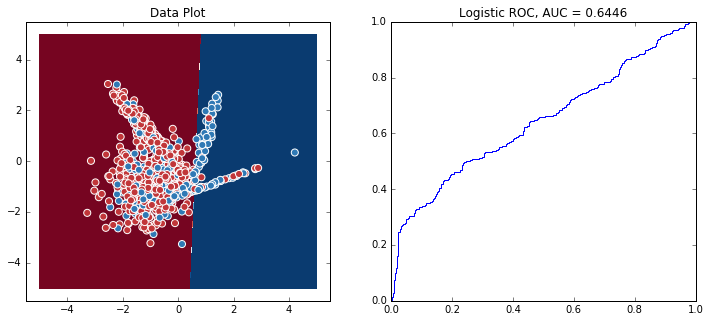

In [22]:
####### try some harder data
### visualization for 2D data point

X, Y =  datasets.make_classification(1000, 2, 2, 0, weights=[0.9, 0.1], flip_y=0.4)

fig = plt.figure( figsize=(12, 5) )
ax = fig.add_subplot(121)
plt.title('Data Plot')

log_model =  linear_model.LogisticRegression()
log_model.fit(X, Y)
Y_pred = log_model.predict_proba(X)

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = log_model.predict(grid).reshape(xx.shape)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)

plt.scatter(X[:,0], X[:, 1], c=Y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

fig.add_subplot(122)
fpr, tpr, _ = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
auc = sklearn.metrics.roc_auc_score(Y, Y_pred[:,1])

plt.plot(fpr, tpr)
plt.title('Logistic ROC, AUC = ' + str( np.round(auc,4)) )
print 'acc =', np.mean( np.argmax(Y_pred,1)==Y)

In [23]:
# finally we directly optimized AUC
D0 = np.where(Y == 0)[0]; D1 = np.where( Y == 1)[0]

import lasagne
import theano.tensor as T

x = T.matrix('inputs')
y = T.ivector('targets')

model = lasagne.layers.InputLayer(shape = (None, 2), input_var=x)
model = lasagne.layers.DenseLayer(model, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)

prediction = lasagne.layers.get_output(model, inputs = x)

# the only difference we use here is we use negative AUC as loss
label_we_care = 1
init_loss = T.fscalar('auc_loss')
auc_loss = init_loss + 0.0
for k in xrange(d+1):
    for l in xrange(k+1):
        auc_loss = auc_loss-alphas[d][k,l]*T.sum( T.pow( prediction[:,label_we_care], l) *T.eq(y, label_we_care) )\
                                        *T.sum( T.pow( prediction[:,label_we_care], k-l) * T.neq(y, label_we_care))
auc_loss /= len(D0) * len(D1)      

params = lasagne.layers.get_all_params(model, trainable=True)
updates_auc = lasagne.updates.nesterov_momentum(auc_loss, params, learning_rate=0.01, momentum=0.9)
train_model = theano.function([x, y, init_loss], auc_loss, updates=updates_auc)

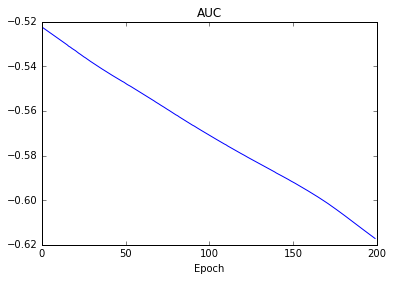

In [26]:
X = X.astype(np.float32); Y = Y.astype(np.int32)
loss_epoch = []
for i in xrange(200):
    loss_epoch.append( train_model(X, Y, 0.0) )
    
plt.plot(loss_epoch)
plt.title('AUC')
plt.xlabel('Epoch')

In [ ]:
#######################################################
# debug below
#######################################################

In [240]:
def s1(l):
    return np.sum( target_pred[Y==1,1] ** l ) 
def s2(k,l):
    return np.sum( target_pred[Y==0,1] ** (k-l) )

tmp = 0
for k in xrange(d+1):
    for l in xrange(k+1):
        tmp += alphas[d][k,l] * s1(l) * s2(k,l) 
        print s1(l) - np.sum( np.power( target_pred[D1,1], l) ), s2(k,l) - np.sum( np.power( target_pred[D0,1], k-l ) ) 
print tmp / len(D0) / len(D1)

auc_poly = 0
for k in xrange(d+1):
    for l in xrange(k+1):
        #print s1(l) -  np.sum( np.power( target_pred[D1,1], l) ) 
        auc_poly += alphas[d][k,l] * np.sum( np.power( target_pred[D1,1], l) ) * np.sum( np.power( target_pred[D0,1], k-l ) )
auc_poly /= len(D0) * len(D1) * 1.0
print auc_poly

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.820457728034
0.820457728034


In [225]:
k = 2; l = 1
print s1(l) - np.sum( np.power( target_pred[D1,1], l) )

7.62620597788


In [230]:
l

1

In [226]:
np.power( target_pred[D1,1], l)

array([ 0.207,  0.824,  0.391,  0.206,  0.781,  0.302,  0.845,  0.512,
        0.627,  0.81 ,  0.75 ,  0.883,  0.199,  0.455,  0.862,  0.897,
        0.255,  0.822,  0.742,  0.244,  0.886,  0.895,  0.828,  0.87 ,
        0.457,  0.885,  0.556,  0.786,  0.262,  0.438,  0.886,  0.247,
        0.71 ,  0.403,  0.21 ,  0.875,  0.824,  0.969,  0.967,  0.908,
        0.31 ,  0.081,  0.809,  0.963,  0.957,  0.314,  0.145,  0.844,
        0.849,  0.915,  0.22 ,  0.95 ,  0.635,  0.648,  0.816,  0.365,
        0.33 ,  0.473,  0.68 ,  0.431,  0.283,  0.763])

In [227]:
target_pred[Y==1,1] ** l

array([ 0.824,  0.391,  0.781,  0.302,  0.845,  0.627,  0.81 ,  0.75 ,
        0.883,  0.862,  0.897,  0.822,  0.742,  0.828,  0.87 ,  0.885,
        0.556,  0.786,  0.262,  0.886,  0.247,  0.71 ,  0.21 ,  0.875,
        0.824,  0.969,  0.967,  0.908,  0.31 ,  0.809,  0.963,  0.957,
        0.314,  0.844,  0.849,  0.915,  0.95 ,  0.635,  0.816,  0.33 ,
        0.283,  0.834,  0.957,  0.539,  0.809,  0.861,  0.676,  0.857,
        0.316,  0.882,  0.872,  0.927,  0.862,  0.875,  0.21 ,  0.913,
        0.966,  0.982,  0.807,  0.864,  0.913,  0.667])

In [232]:
target_pred[D1,1]

array([ 0.207,  0.824,  0.391,  0.206,  0.781,  0.302,  0.845,  0.512,
        0.627,  0.81 ,  0.75 ,  0.883,  0.199,  0.455,  0.862,  0.897,
        0.255,  0.822,  0.742,  0.244,  0.886,  0.895,  0.828,  0.87 ,
        0.457,  0.885,  0.556,  0.786,  0.262,  0.438,  0.886,  0.247,
        0.71 ,  0.403,  0.21 ,  0.875,  0.824,  0.969,  0.967,  0.908,
        0.31 ,  0.081,  0.809,  0.963,  0.957,  0.314,  0.145,  0.844,
        0.849,  0.915,  0.22 ,  0.95 ,  0.635,  0.648,  0.816,  0.365,
        0.33 ,  0.473,  0.68 ,  0.431,  0.283,  0.763])

In [234]:
Y[D1]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

reference:

(1) AUC Optimization vs. Error Rate Minimization 

(2) Efficient AUC Optimization for Classification